# IRRADIANCIA RESUELTA ESPECTRALMENTE

In [34]:
from pvlib import spectrum, solarposition, irradiance, atmosphere
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline as interp

Se presentan todas las caracteristicas necesarias para concoer la irradiancia espectral

In [35]:
caracteristics={
    'lat':40.544,
    'lon':-3.613,
    'tz':'Europe/Madrid',
    'date':'2021-03-21 8:00',
    'pressure':92350,
    'water_vapor_content':0.6,
    'tau500':0.1,
    'ozone':0.308,
    'albedo':0.2,
    }
caracteristics_module={    
    'tilt':20,
    'surface_azimuth':180,
    'radius':0.6,
    'area':179*10**-6
    }


In [36]:
times = pd.date_range(caracteristics['date'], freq='60min', periods=12,tz=caracteristics['tz'])
solpos = solarposition.get_solarposition(times, caracteristics['lat'], caracteristics['lon'])
aoi = irradiance.aoi(caracteristics_module['tilt'], caracteristics_module['surface_azimuth'], solpos.apparent_zenith, solpos.azimuth)
relative_airmass = atmosphere.get_relative_airmass(solpos.apparent_zenith,model='kasten1966')

In [37]:
spectra = spectrum.spectrl2(
    apparent_zenith=solpos.apparent_zenith,
    aoi=aoi,
    surface_tilt=caracteristics_module['tilt'],
    ground_albedo=caracteristics['albedo'],
    surface_pressure=caracteristics['pressure'],
    relative_airmass=relative_airmass,
    precipitable_water=caracteristics['water_vapor_content'],
    ozone=caracteristics['ozone'],
    aerosol_turbidity_500nm=caracteristics['tau500'],
)

Podemos obtener así la distirbución espectral a lo largo de un día para distintas horas

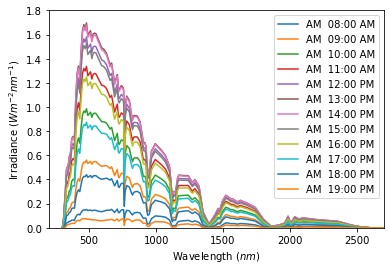

In [38]:
plt.figure()
plt.plot(spectra['wavelength'], spectra['poa_global'])
plt.xlim(200, 2700)
plt.ylim(0, 1.8)
plt.ylabel(r"Irradiance ($W m^{-2} nm^{-1}$)")
plt.xlabel(r"Wavelength ($nm$)")

time_labels = times.strftime("%H:%M %p")
labels = [
    "AM  {}".format(*vals)
    for vals in zip(time_labels)
]
plt.legend(labels)
plt.show()

380.0 0.06401186657512371 24.32450929854701
390.0 0.0614512771260078 48.29050737769005
400.0 0.09031045372823268 84.41468886898312
410.0 0.10692764614845016 128.25502378984768
420.0 0.11281877029342956 175.6389073130881
430.0 0.10629669491259709 221.34648612550487
440.0 0.12727057370577083 277.34553855604406
450.0 0.14296907629813466 341.68162289020466
460.0 0.1480422574246599 409.78106130554823
470.0 0.14650320522750307 478.63756776247465
480.0 0.15157937789115156 551.3956691502274
490.0 0.14328344504624815 621.604557222889
500.0 0.1452183793468692 694.2137468963235
510.0 0.14723125056165012 769.3016846827651
520.0 0.14102613064571584 842.6352726185373
530.0 0.14467182938743842 919.3113421938797
540.0 0.14501417028893032 997.618994149902
550.0 0.14483646519759585 1077.2790500085798
570.0 0.13681482461447997 1155.2635000388334
593.0 0.1332650854883138 1234.2896957334035
610.0 0.13821578997066794 1318.6013276155109
630.0 0.14543015341426946 1410.2223242665007
656.0 0.14581192733333917 1

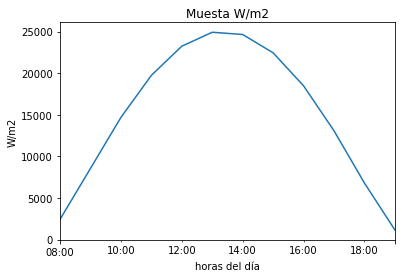

In [41]:
hour_irrad=[]
for i in range(len(spectra['poa_global'][0])):
    a=0
    for j in range(len(spectra['poa_global'])):
        if spectra['wavelength'][j]>=380 and spectra['wavelength'][j]<=770 :
                a=a+float(spectra['wavelength'][j])*float(spectra['poa_global'][j][i])
                print(spectra['wavelength'][j],float(spectra['poa_global'][j][i]),a)
    hour_irrad.append(a)

hour_irrad=pd.Series(hour_irrad)
hour_irrad.index=times
hour_irrad.plot()
plt.xlabel('horas del día')
plt.ylabel('W/m2')
plt.title("Muesta W/m2")
plt.show()


# CURVA FOTOPICA VALORES

Se extraen los valores normalizados de la curva fotópica en tanto por uno

In [42]:

effic=[0.000039,0.000120,0.000396,0.001210,0.004000,0.011600,0.023000,0.038000,0.060000,0.090980,0.139020,0.208020,0.32300,0.444310, 0.503000,0.710000,0.862000,0.954000,0.994950,1.000000,0.995000,0.952000,0.870000,0.757000,0.631000,0.503000,0.381000,0.265000,0.175000, 0.107000,0.061000,0.032000,0.017000,0.008210,0.004102,0.002091,0.001047,0.000520,0.000249,0.000120,0.000060,0.000030]
wave_len=[380,390,400,410,420,430,440,450,460,470,480,490,500,507,510, 520, 530, 540, 550,555,560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770]

effic_=pd.Series(effic)
effic_.index=wave_len


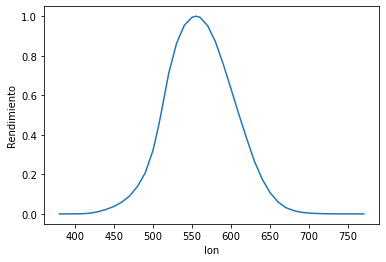

In [43]:
effic_.plot()
plt.xlabel('lon')
plt.ylabel('Rendimiento')
plt.show()

In [44]:
photopic_curve=interp(wave_len,effic,k=3)

# USO CURVA FOTOPICA CON LA IRRADIANCIA ESPECTRAL

Aplicamos a la irradiancia espectral la integral de la fotópica, para así obtener la irradiancia real que se va a utilizar para iluminacion

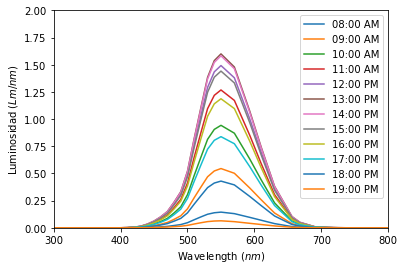

In [45]:
irrad_phot=[]
for i in range(len(spectra['poa_global'])):
    irrad_phot.append(spectra['poa_global'][i]*photopic_curve(spectra['wavelength'][i]))

plt.figure()
plt.plot(spectra['wavelength'], irrad_phot)
plt.xlim(300, 800)
plt.ylim(0, 2)
plt.ylabel(r"Luminosidad ($Lm/nm$)")
plt.xlabel(r"Wavelength ($nm$)")

time_labels = times.strftime("%H:%M %p")
labels = [
    "{}".format(*vals)
    for vals in zip(time_labels)
]
plt.legend(labels)

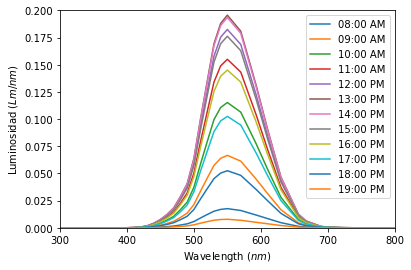

In [52]:
uwu=[]
for i in range(len(spectra['poa_global'])):
    uwu.append(irrad_phot[i]*683*caracteristics_module['area'])

plt.figure()
plt.plot(spectra['wavelength'], irrad_phot)
plt.xlim(300, 800)
plt.ylim(0, 0.2)
plt.ylabel(r"Luminosidad ($Lm/nm$)")
plt.xlabel(r"Wavelength ($nm$)")

time_labels = times.strftime("%H:%M %p")
labels = [
    "{}".format(*vals)
    for vals in zip(time_labels)
]
plt.legend(labels)

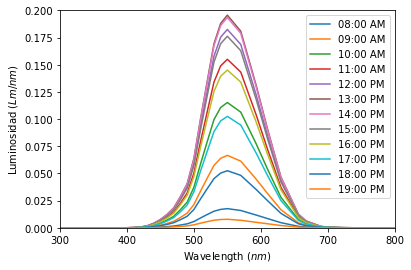

In [47]:
irrad_phot=[]
for i in range(len(spectra['poa_global'])):
    irrad_phot.append(spectra['poa_global'][i]*photopic_curve(spectra['wavelength'][i])*caracteristics_module['area']*683)

plt.figure()
plt.plot(spectra['wavelength'], irrad_phot)
plt.xlim(300, 800)
plt.ylim(0, 0.2)
plt.ylabel(r"Luminosidad ($Lm/nm$)")
plt.xlabel(r"Wavelength ($nm$)")

time_labels = times.strftime("%H:%M %p")
labels = [
    "{}".format(*vals)
    for vals in zip(time_labels)
]
plt.legend(labels)
plt.show()

Esta distribución es un sistema aditivo. Se puede obtener el valor de la irradiancia total a una hora concreta haciendo el sumatorio del producto de cada longitud de onda por el valor de irradiancia espectral. 

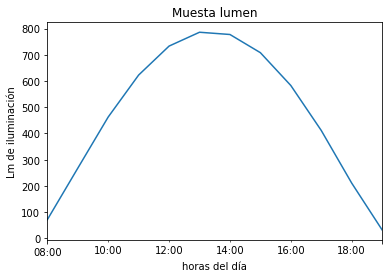

In [48]:
hour_irrad=[]
for i in range(len(irrad_phot[0])):
    a=0
    for j in range(len(irrad_phot)):
        if spectra['wavelength'][j]>=380 and spectra['wavelength'][j]<=770 :
                a=a+float(spectra['wavelength'][j])*float(irrad_phot[j][i])
    hour_irrad.append(a)

hour_irrad=pd.Series(hour_irrad)
hour_irrad.index=times
hour_irrad.plot()
plt.xlabel('horas del día')
plt.ylabel('Lm de iluminación')
plt.title("Muesta lumen")
plt.show()
